# BLOCK-T227 - Dynamic Tests at 34º - short and long slews

In [32]:
#%load_ext lab_black
import numpy as np
import os

from matplotlib import pyplot as plt
from lsst.ts.observing import ObservingBlock, ObservingScript

In [33]:
name = "BLOCK-T227"
program = "BLOCK-T227"
reason = "LVV-T2811"
constraints = []
scripts = []

output_folder = "output_blocks"
elevation = 34.0  # degrees
azimuth = -75.0  # degrees

In [34]:
def build_configuration_schema(block_number, properties):
    """
    Builds a configuration schema string for a given BLOCK and configurable
    properties.

    Parameters
    ----------
    block_number :
        The BLOCK number to include in the title and description.
    properties : dict
        A dictionary where each key is a property name, and each value is a
        dictionary with keys 'description', 'type', and optionally 'default'.

    Returns
    -------
        A formatted configuration schema string.
    """

    # Define the base schema with the BLOCK number
    configuration_schema = (
        "$schema: http://json-schema.org/draft-07/schema#\n"
        f"title: BLOCK-{block_number} configuration\n"
        f"description: Configuration for BLOCK-{block_number}.\n"
        "type: object\n"
        "properties:\n"
    )

    # Add each property to the schema
    for prop_name, prop_details in properties.items():
        configuration_schema += f"  {prop_name}:\n"
        configuration_schema += f'    description: {prop_details["description"]}\n'
        configuration_schema += f'    type: {prop_details["type"]}\n'
        if "default" in prop_details:
            # Add quotes around the default value if it's a string
            default_value = prop_details["default"]
            if prop_details["type"] == "string":
                default_value = f'"{default_value}"'
            configuration_schema += f"    default: {default_value}\n"

    return configuration_schema

Define the configurable properties that we will use in the configuration schema

In [35]:
properties = {
    "ignore": {
        "description": "Name of the CSCs we want to ignore",
        "type": "array",
        "default": [],
    },
    "move_timeout": {
        "description": "Timeout for the move_p2p.py scripts",
        "type": "number",
        "default": 1800,
    },
    
}

block_number = name.split("-")[-1]
configuration_schema = build_configuration_schema(block_number, properties)
print(configuration_schema)

$schema: http://json-schema.org/draft-07/schema#
title: BLOCK-T227 configuration
description: Configuration for BLOCK-T227.
type: object
properties:
  ignore:
    description: Name of the CSCs we want to ignore
    type: array
    default: []
  move_timeout:
    description: Timeout for the move_p2p.py scripts
    type: number
    default: 1800



In [36]:
3.5 / np.sqrt(2)

2.4748737341529163

In [37]:
azel_slew_offsets = [
    (0, 0),
    (0, 12),
    (0, -12),
    (24, 0),
    (-24, 0),
    (0, 3.5),
    (0, -3.5),
    (3.5, 0),
    (-3.5, 0),
    (8.48, 8.48),
    (-8.48, 8.48),
    (-8.48, -8.48),
    (8.48, -8.48),
    (2.47, 2.47),
    (-2.47, 2.47),
    (-2.47, -2.47),
    (2.47, -2.47),
]
absolute_coordinates = []

for az, el in azel_slew_offsets:
    azimuth += az
    elevation += el
    print(
        f"Add move_p2p script to point at az={azimuth:.2f} deg and el = {elevation:.2f}"
    )
    move_p2p = ObservingScript(
        name="maintel/move_p2p.py",
        standard=True,
        parameters=dict(az=azimuth, el=elevation, move_timeout="$move_timeout", ignore="$ignore"),
    )
    sleep = ObservingScript(
        name="sleep.py", standard=True, parameters=dict(sleep_for=30)
    )

    scripts.append(move_p2p)
    scripts.append(sleep)
    absolute_coordinates.append((azimuth, elevation))

Add move_p2p script to point at az=-75.00 deg and el = 34.00
Add move_p2p script to point at az=-75.00 deg and el = 46.00
Add move_p2p script to point at az=-75.00 deg and el = 34.00
Add move_p2p script to point at az=-51.00 deg and el = 34.00
Add move_p2p script to point at az=-75.00 deg and el = 34.00
Add move_p2p script to point at az=-75.00 deg and el = 37.50
Add move_p2p script to point at az=-75.00 deg and el = 34.00
Add move_p2p script to point at az=-71.50 deg and el = 34.00
Add move_p2p script to point at az=-75.00 deg and el = 34.00
Add move_p2p script to point at az=-66.52 deg and el = 42.48
Add move_p2p script to point at az=-75.00 deg and el = 50.96
Add move_p2p script to point at az=-83.48 deg and el = 42.48
Add move_p2p script to point at az=-75.00 deg and el = 34.00
Add move_p2p script to point at az=-72.53 deg and el = 36.47
Add move_p2p script to point at az=-75.00 deg and el = 38.94
Add move_p2p script to point at az=-77.47 deg and el = 36.47
Add move_p2p script to p

In [38]:
block = ObservingBlock(
    name=name,
    program=program,
    configuration_schema=configuration_schema,
    scripts=scripts,
)

In [39]:
block.model_dump_json(indent=2)

os.makedirs(output_folder, exist_ok=True)
output_path = f"{output_folder}/{name}.json"

with open(output_path, "w") as file:
    file.write(block.model_dump_json(indent=2))

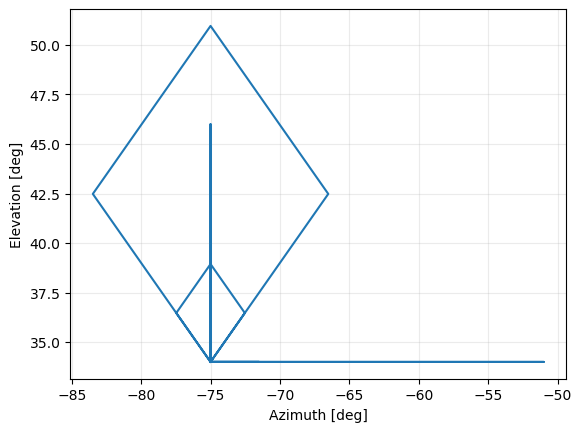

In [40]:
fig, ax = plt.subplots()

coords = np.array(absolute_coordinates)

ax.plot(coords.T[0], coords.T[1])
ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Elevation [deg]")
ax.grid(":", alpha=0.25)

plt.show()